# Kinematics for V4

This notebook generates a lookup table as source code (the laziest way I could think of linking it!) 

In [3]:
""" 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Imports, constants ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""

import pandas as pd
import numpy as np
from sympy import *  # so that our systems of equations can be declared cleanly
import math  # note that a lot of these functions clash with sympy so I'll reference them from the math package specififically
import seaborn as sns
%matplotlib inline

# Maximum dimensions: one sheet of plywood, 4' x 8'.
H = 4 * 12  # inches
W = 8 * 12  # inches

# String maximum length is the hypotenuse of said 4' x 8' sheet of plywood, which works out to 108 inches (leaving the math in there just in case)
STRING_LENGTH_IN = math.ceil(math.sqrt(H**2 + W**2))  # I'm using ceil() to cast to integer so I can use this as an index.
LUT_RESOLUTION_IN = 1  # inches (must be integer! I'm using )

LUT_SIZE = int(STRING_LENGTH_IN / LUT_RESOLUTION_IN)

In [96]:
""" 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Lookup table initialization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

I'm tracking string length using step pulse generation routines or encoders (still haven't exactly decided yet), so I'm thinking I'll look up from that --
it's the one quantity I feel sure I'll know accurately (well, modulo mechanical imprecision like string stacking up on the pulley).

The things I really want to know at any given time are:
* Where am I?
* How do I spin my motors in order to achieve a particular velocity in (x,y)?

Note that it might also make sense to generate a lookup from (x, y) to (l1, l2) that can help us do path planning. But for now I'm gonna ignore that because
I'm not working on path planning yet, I'm just trying to get the joystick to work (and the joystick is best understood as a request for velocity, dx/dt and dy/dt).

So my lookup is going to be from (l1, l2) to the x,y) coordinate system AND to the partial deriviatives of l1 and l2 with regard to x and y. 
That way I'm pretty sure I'll be able to calculate motor velocities as follows:

>    ω1 = dl1/dt / (pi * r)   (where ω, lower-case omega, is the symbol for angular velocity in radians/second)
>    dl1/dt = (dx/dt * dl1/dx)

I'm planning on doing one point per inch. Across 108" of string, that's 108x108 = 11,664 points; with six four-byte floats (or fixed-point numbers, sigh) 
per point, that's 280 kB (kilo = 1000; aka 273 kibibytes). So it's enough to fit in flash for an Arduino Due or the LPC1768 on the BigTreeTech SKR V1.4.

Note that I'm too lazy to figure out 3d data structures, so I'm just gonna do this as a set of individually named DataFrames. :shrug: why not!
"""

lut_x = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))
lut_y = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))
lut_dl1dx = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))
lut_dl1dy = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))
lut_dl2dx = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))
lut_dl2dy = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))

# TODO do I want these too? Maybe I'll want to calculate them for the animation?
#lut_θ1 = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))  # special symbols are a pain you say? 🤓 sorryyyyy
#lut_θ2 = pd.DataFrame(np.zeros((LUT_SIZE, LUT_SIZE)))


# X, Y position

## Calculation

In [97]:
""" 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Math ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

I have this written out in my notebook; I won't explain the math too much here. Just trying to comment enough to help rederive.

Coordinate system is as follows:

_______________________________________________________________________
|(0,0) -----> x                                                       |
|  |                                                                  |
|  |                                                                  |
|  |                                                                  |
|  v  y                                                               |
|                                                                     |
|                                                                     |
|                                                                     |
|                                                                     |
|                                                                     |
|                                                                     |
_______________________________________________________________________
"""

from collections import namedtuple
StringLengths = namedtuple('StringLengths', ['l1', 'l2'])


for l1 in range(0, STRING_LENGTH_IN, LUT_RESOLUTION_IN):
    for l2 in range(0, STRING_LENGTH_IN, LUT_RESOLUTION_IN):

        i1 = int(l1/LUT_RESOLUTION_IN)
        i2 = int(l2/LUT_RESOLUTION_IN)

        lut_key = (i2, i1)

        if l1 + l2 < W:
            # strings don't reach each other; mark as invalid
            lut_x.iloc[lut_key] = np.nan
            lut_y.iloc[lut_key] = np.nan
            continue

        # Find x, y using Pythagorean theorem. Note that we can find x first using the "y identity" on the two string lengths --
        # that is, knowing that (l1^2 - x^2) = y^2 = (l2^2 - (W-x)^2), where W is the full width of the system.
        x = (l1**2 - l2**2 + W**2) / (2 * W)  # note that the x^2 cancels out, leaving a x^1 term from (W-x)^2 -- hence no square root!

        if (x < 0) or (x > W):
            # off the platform; mark as invalid
            lut_x.iloc[lut_key] = np.nan
            lut_y.iloc[lut_key] = np.nan
            continue

        y = math.sqrt(l1**2 - x**2)
        
        if y > H:
            # off the bottom of the platform
            lut_x.iloc[lut_key] = np.nan
            lut_y.iloc[lut_key] = np.nan
            continue
        
        lut_x.iloc[lut_key] = x
        lut_y.iloc[lut_key] = y

## Plots

Let's plot this out with Seaborn to confirm that it's valid.

Text(0.5, 1.0, 'X position')

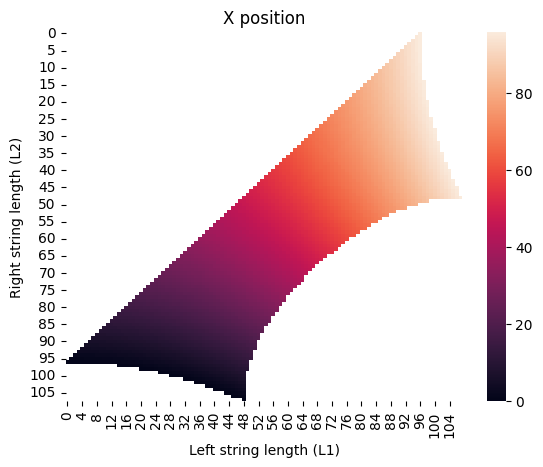

In [18]:
ax = sns.heatmap(lut_x)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("X position")

Text(0.5, 1.0, 'Y position')

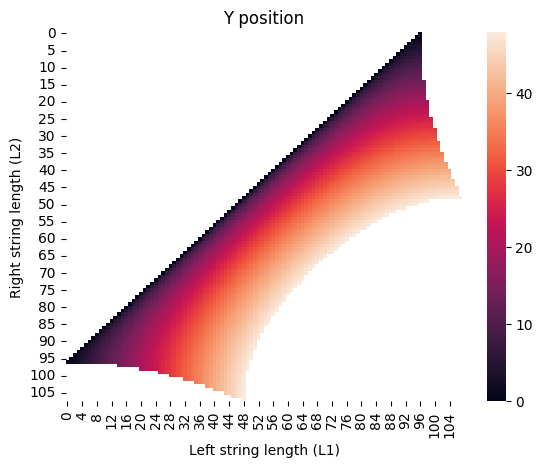

In [28]:
ax = sns.heatmap(lut_y)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("Y position")

# Animation (unfinished)

Unfinished: an aborted attempt at some animation to show the thing moving around. I don't think I need this;
the graphs are pretty clearly correct on inspection. I'm just gonna try moving motors and see what happens!

In [161]:
unused_code="""
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
from collections import namedtuple

# Initialize the plot
fig, ax = plt.subplots()
ax.set_xlim(0, W)
ax.set_ylim(0, H)
carriage, = ax.plot([], [], 'bo')  # Carriage point
left_string, = ax.plot([], [], 'r-')  # String from left motor
right_string, = ax.plot([], [], 'g-')  # String from right motor

# Animation update function
def update(frame: StringLengths):
    
    x = lut_x
    
    # Update carriage position
    carriage.set_data(X, Y)

    # Update strings
    left_string.set_data([0, X], [H, Y])
    right_string.set_data([W, X], [H, Y])

    return carriage, left_string, right_string

# Create a list or array of (L1, L2) pairs for the animation frames
# Example: varying L1 and L2 between certain ranges
frames = [(L1, L2) for L1 in np.linspace(1, 15, 100) for L2 in np.linspace(1, 15, 100)]

# Create the animation
ani = FuncAnimation(fig, update, frames=frames, blit=True)

plt.show()
"""

# Derivatives

I expect to know how fast I want to go in x and y -- either from the joystick or sent by the vision system.

I'm gonna call those numbers `dx/dt` and `dy/dt`.

Ideally we have an equation that looks like this:

\frac{a}{b}

In [43]:
from sympy import diff, symbols, sqrt

# Define the symbols
l1, l2, W, x, y, t = symbols('l1 l2 W x y t')
dx_dt, dy_dt = symbols('dx_dt dy_dt')

# Express l1 and l2 in terms of x and y
l1_expr = sqrt(x**2 + y**2)
l2_expr = sqrt((W - x)**2 + y**2)

# Differentiate l1 and l2 with respect to time
dl1_dt = diff(l1_expr, x) * dx_dt + diff(l1_expr, y) * dy_dt
dl2_dt = diff(l2_expr, x) * dx_dt + diff(l2_expr, y) * dy_dt

dl1_dt, dl2_dt

(dx_dt*x/sqrt(x**2 + y**2) + dy_dt*y/sqrt(x**2 + y**2),
 dx_dt*(-W + x)/sqrt(y**2 + (W - x)**2) + dy_dt*y/sqrt(y**2 + (W - x)**2))

In [99]:
# Iterate over possible l1 and l2 values
for l1 in range(0, STRING_LENGTH_IN, LUT_RESOLUTION_IN):
    for l2 in range(0, STRING_LENGTH_IN, LUT_RESOLUTION_IN):

        i1 = int(l1 / LUT_RESOLUTION_IN)
        i2 = int(l2 / LUT_RESOLUTION_IN)

        lut_key = (i2, i1)

        x = lut_x.iloc[lut_key]
        y = lut_y.iloc[lut_key]

        # Check for NaN values in lut_x and lut_y
        if np.isnan(x) or np.isnan(y):
            lut_dl1dx.iloc[lut_key] = np.nan
            lut_dl1dy.iloc[lut_key] = np.nan
            lut_dl2dx.iloc[lut_key] = np.nan
            lut_dl2dy.iloc[lut_key] = np.nan
        else:
            # Substitute and evaluate expressions
            lut_dl1dx.iloc[lut_key] = x / math.sqrt(x**2 + y**2)
            lut_dl1dy.iloc[lut_key] = y / math.sqrt(x**2 + y**2)
            lut_dl2dx.iloc[lut_key] = (x - W) / math.sqrt(y**2 + (W-x)**2)
            lut_dl2dy.iloc[lut_key] = y / math.sqrt(y**2 + (W-x)**2)

/var/folders/p9/dr4mbmw945s1dp4xd7r_msrr0000gn/T/ipykernel_24149/625791842.py:21: RuntimeWarning: invalid value encountered in scalar divide
  lut_dl1dx.iloc[lut_key] = x / math.sqrt(x**2 + y**2)
/var/folders/p9/dr4mbmw945s1dp4xd7r_msrr0000gn/T/ipykernel_24149/625791842.py:22: RuntimeWarning: invalid value encountered in scalar divide
  lut_dl1dy.iloc[lut_key] = y / math.sqrt(x**2 + y**2)
/var/folders/p9/dr4mbmw945s1dp4xd7r_msrr0000gn/T/ipykernel_24149/625791842.py:23: RuntimeWarning: invalid value encountered in scalar divide
  lut_dl2dx.iloc[lut_key] = (x - W) / math.sqrt(y**2 + (W-x)**2)
/var/folders/p9/dr4mbmw945s1dp4xd7r_msrr0000gn/T/ipykernel_24149/625791842.py:24: RuntimeWarning: invalid value encountered in scalar divide
  lut_dl2dy.iloc[lut_key] = y / math.sqrt(y**2 + (W-x)**2)


## Plots

Again, let's see what this looks like:

Text(0.5, 1.0, 'Partial derivative of L1 with regard to X, δl1/δx')

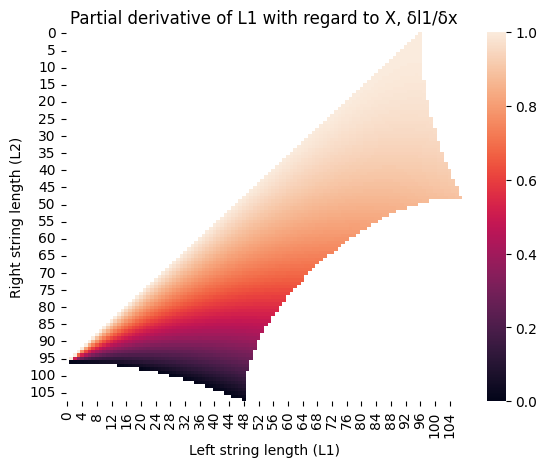

In [100]:
ax = sns.heatmap(lut_dl1dx)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("Partial derivative of L1 with regard to X, δl1/δx")

Text(0.5, 1.0, 'Partial derivative of L1 with regard to Y, δl1/δy')

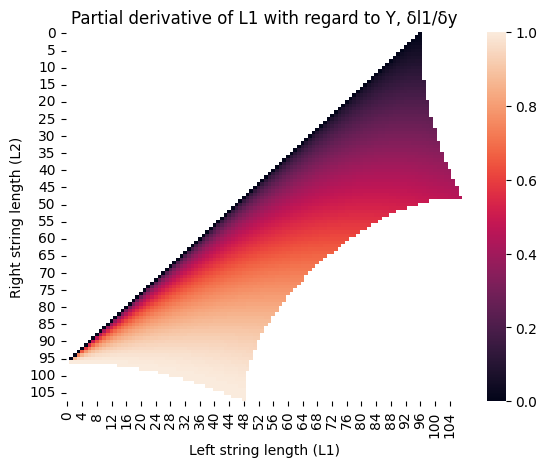

In [101]:
ax = sns.heatmap(lut_dl1dy)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("Partial derivative of L1 with regard to Y, δl1/δy")

In [77]:
lut_dl2dx

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Partial derivative of L2 with regard to X, δl2/δx')

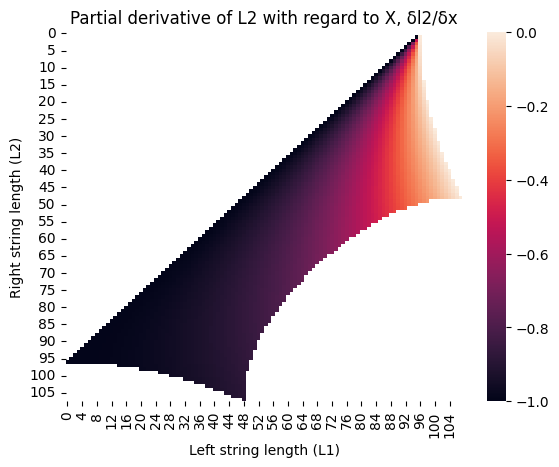

In [102]:
ax = sns.heatmap(lut_dl2dx)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("Partial derivative of L2 with regard to X, δl2/δx")

Text(0.5, 1.0, 'Partial derivative of L2 with regard to Y, δl2/δy')

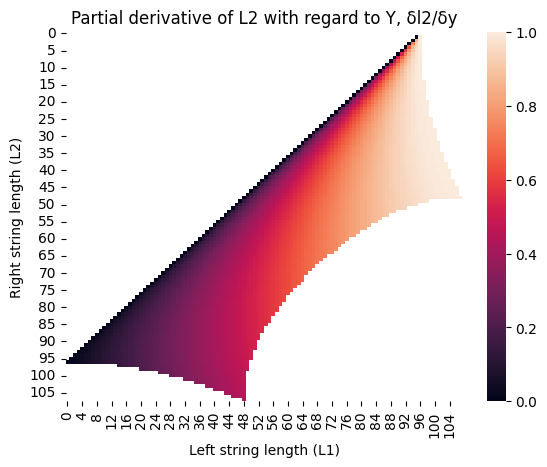

In [103]:
ax = sns.heatmap(lut_dl2dy)
ax.set_xlabel("Left string length (L1)")
ax.set_ylabel("Right string length (L2)")
ax.set_title("Partial derivative of L2 with regard to Y, δl2/δy")

In [55]:
# TODO remove me -- this is just me checking a single value to troubleshoot my math

x = 12
y = 24
l1 = math.sqrt(x**2 + y**2)
l2 = math.sqrt((W-x)**2 + y**2)
lut_key = (int(l2), int(l1))

print(f"x: {x}, y: {y}, l1: {l1}, l2: {l2}, lut_key: {lut_key}")
print(f"Lookup value of x: {lut_x.iloc[lut_key]}")
print(f"Lookup value of y: {lut_y.iloc[lut_key]}")

float(dl1_dx_expr.subs({x: lut_x.iloc[lut_key], y: lut_y.iloc[lut_key]}).evalf())

x: 12, y: 24, l1: 26.832815729997478, l2: 87.36131867136622, lut_key: (87, 26)
Lookup value of x: 12.098958333333334
Lookup value of y: 23.013370184487624


0.8944271909999159

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Code generation

Here we plug these numbers into a giant fucking C++ array.

TODO figure out some mapping function that reduces the area of the 

In [153]:
import pandas as pd
cpp_template="""/* 
 * kinematics.cpp
 * 
 * This library is auto-generated from the Jupyter notebook v4_kinematics.ipynb.
 * 
 * It contains a giant lookup table from string length (L2, L1) to x, y, and the four partial
 * derivatives of L1 and L2 with regard to X and Y. The microcontroller can track string length
 * using either encoders (for brushed/brushless) or step pulse counting (for steppers). Given a
 * target velocity dx/dt and dy/dt, we can calculate dl1/dt and dl2/dt using the chain rule:
 *
 * dl1/dt = (δl1/δx) * dx/dt + (δl1/δy) * dy/dt
 * dl2/dt = (δl2/δx) * dx/dt + (δl2/δy) * dy/dt
 * 
 * It's useful to know X and Y so the microcontroller can take position commands as well as
 * speed commands. We'll do that with a feedback loop on the microcontroller -- ie if our current
 * position is at larger X than the requested, we'll accelerate in the negative X direction, and so on.
 */

#include <cmath> // Include cmath for NAN

const LookupEntry lookupTable[108][108] = {
{% for l1 in range(108) %}
    {
    {% for l2 in range(108) %}
        {
            {% if pd.isna(lut_x.iloc[l1, l2]) %}NAN{% else %}{{ lut_x.iloc[l1, l2] }}{% endif %},
            {% if pd.isna(lut_y.iloc[l1, l2]) %}NAN{% else %}{{ lut_y.iloc[l1, l2] }}{% endif %},
            {% if pd.isna(lut_dl1dx.iloc[l1, l2]) %}NAN{% else %}{{ lut_dl1dx.iloc[l1, l2] }}{% endif %},
            {% if pd.isna(lut_dl1dy.iloc[l1, l2]) %}NAN{% else %}{{ lut_dl1dy.iloc[l1, l2] }}{% endif %},
            {% if pd.isna(lut_dl2dx.iloc[l1, l2]) %}NAN{% else %}{{ lut_dl2dx.iloc[l1, l2] }}{% endif %},
            {% if pd.isna(lut_dl2dy.iloc[l1, l2]) %}NAN{% else %}{{ lut_dl2dy.iloc[l1, l2] }}{% endif %}
        }
    {% endfor %}
    },
{% endfor %}
};
"""

# Render the template
template = Template(cpp_template)
cpp_code = template.render(pd=pd, lut_x=lut_x, lut_y=lut_y, lut_dl1dx=lut_dl1dx, lut_dl1dy=lut_dl1dy, lut_dl2dx=lut_dl2dx, lut_dl2dy=lut_dl2dy)

# Print or write to file for debugging
with open("kinematics.cpp", "w") as file:
    file.write(cpp_code)

In [158]:
h_template="""/* 
 * kinematics.h
 * 
 * This library is auto-generated from the Jupyter notebook v4_kinematics.ipynb.
 * 
 * It contains a giant lookup table from string length (L2, L1) to x, y, and the four partial
 * derivatives of L1 and L2 with regard to X and Y. The microcontroller can track string length
 * using either encoders (for brushed/brushless) or step pulse counting (for steppers). Given a
 * target velocity dx/dt and dy/dt, we can calculate dl1/dt and dl2/dt using the chain rule:
 *
 * dl1/dt = (δl1/δx) * dx/dt + (δl1/δy) * dy/dt
 * dl2/dt = (δl2/δx) * dx/dt + (δl2/δy) * dy/dt
 * 
 * It's useful to know X and Y so the microcontroller can take position commands as well as
 * speed commands. We'll do that with a feedback loop on the microcontroller -- ie if our current
 * position is at larger X than the requested, we'll accelerate in the negative X direction, and so on.
 */

struct LookupEntry {
    float x;
    float y;
    float dl1_dx;
    float dl1_dy;
    float dl2_dx;
    float dl2_dy;
};

// The contents of the lookup table are populated in kinematics.cpp, of course
const LookupEntry lookupTable[108][108];
"""

# Render the template
template = Template(h_template)
h_code = template.render(pd=pd, lut_x=lut_x, lut_y=lut_y, lut_dl1dx=lut_dl1dx, lut_dl1dy=lut_dl1dy, lut_dl2dx=lut_dl2dx, lut_dl2dy=lut_dl2dy)

# Print or write to file for debugging
with open("kinematics.h", "w") as file:
    file.write(h_code)